# Final Project 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm
from tabulate import tabulate
import requests
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
from scipy.stats import norm
import statsmodels.api as sm
from pandas_datareader import data

/Users/zoeyzheng/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Step 1 Data

In [2]:
#Self defined parameters 
N = 1000000
T = 3
delta = 3
k = 1
k_prime = 1
t = '2015-11-01'
days = 252
start_date = datetime.strptime(t, '%Y-%m-%d').date() + relativedelta(years=T)
end_date = start_date + relativedelta(months=delta)
start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

In [3]:
## data source: https://www.newyorkfed.org/markets/reference-rates/sofr-averages-and-index
sofr_data = pd.read_excel('SOFR.xlsx')

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
stock_data = yf.download('^STOXX50E','2018-11-01','2023-11-01')

[*********************100%%**********************]  1 of 1 completed


In [5]:
exchange_rate = yf.download('EURUSD=X','2018-11-01','2023-11-01')
exchange_rate

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-01,1.131388,1.141318,1.131375,1.131670,1.131670,0
2018-11-02,1.140277,1.145541,1.137566,1.140329,1.140329,0
2018-11-05,1.139705,1.140641,1.135525,1.139757,1.139757,0
2018-11-06,1.140862,1.143811,1.139328,1.141292,1.141292,0
2018-11-07,1.144099,1.149994,1.140056,1.143851,1.143851,0
...,...,...,...,...,...,...
2023-10-25,1.059535,1.060670,1.056680,1.059535,1.059535,0
2023-10-26,1.056725,1.056971,1.052632,1.056725,1.056725,0
2023-10-27,1.056446,1.059771,1.053630,1.056446,1.056446,0


## Step 2 Simulation Model

### Use historical data to calculate $\delta_f$, $\delta_x$, $\rho_{fx}$ and calculate $\sigma_s$

In [6]:
log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
volatility = log_returns.std()
delta_f = volatility * np.sqrt(252)

log_returns = np.log(exchange_rate['Close'] / exchange_rate['Close'].shift(1))
volatility = log_returns.std()
delta_x = volatility * np.sqrt(252)

aligned_data = stock_data['Close'].align(exchange_rate['Close'], join='inner')

stock_returns = np.log(aligned_data[0] / aligned_data[0].shift(1))
exchange_rate_returns = np.log(aligned_data[1] / aligned_data[1].shift(1))

rho_fx = stock_returns.corr(exchange_rate_returns)

sigma_s = (delta_f**2 + delta_x**2 + 2 * delta_f * delta_x * rho_fx)**0.5

### Use Vasicek to simulate for SOFR 

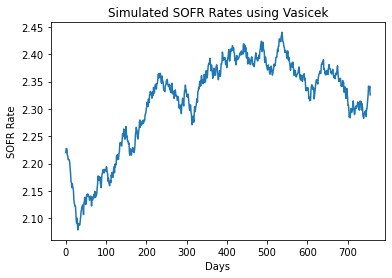

In [7]:
sofr_rates = sofr_data['Rate (%)'].copy()

changes = sofr_rates.diff().dropna()

b = np.mean(sofr_rates)
def vasicek_regression(rates, changes, b):
    dt = 1/252  # Time increment

    # Adjust 'changes' for dt
    y = changes.values / np.sqrt(dt)
    
    X = -1 * (rates[:-1] - b).values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, y)
    a = -model.coef_[0]

    # Estimate sigma
    residuals = y - model.predict(X)
    sigma = np.std(residuals) * np.sqrt(dt)  # Adjust sigma for the time increment

    return a, sigma, b


# Simulate Future SOFR Rates
def simulate_vasicek(b, changes, sofr_rates, days=days*T):
    dt = 1/252 
    rates = [sofr_rates.iloc[-1]]
    historical = sofr_rates
    for _ in range(days):
        a, sigma, b = vasicek_regression(historical, changes, b)
        dr = a * (b - rates[-1]) * dt + sigma * np.random.normal() * np.sqrt(dt)
        rates.append(rates[-1] + dr)
        historical[len(historical)] = rates[-1]
        changes = historical.diff().dropna()
        

    return rates

simulated_rates = simulate_vasicek(b, changes, sofr_rates)

# Step 5: Plot the Results
plt.plot(simulated_rates)
plt.title('Simulated SOFR Rates using Vasicek')
plt.xlabel('Days')
plt.ylabel('SOFR Rate')
plt.show()

#### Transform daily SOFR to term SOFR 

### Use CIR to simulate SOFR

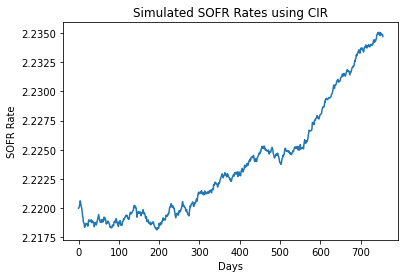

In [8]:
## CIR 
sofr_rates = sofr_data['Rate (%)'].copy()
def param_CIR(historical):
    dt = 1/252  # Time increment

    # Adjust delta_r calculation to include dt
    delta_r = (historical.diff() / (np.sqrt(historical) * np.sqrt(dt))).dropna()

    # Calculate the independent variables X1 and X2
    X1 = np.full_like(delta_r, 1 / (np.sqrt(historical[:-1]) * np.sqrt(dt)))
    X2 = -np.sqrt(historical[:-1])

    X = np.column_stack((X1, X2))

    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(delta_r, X).fit()

    # Extracting parameters
    ab_est, a_est = model.params[1], -model.params[2]
    sigma_est = model.bse[1]

    # You would need additional information to separate `a` and `b`
    b_est = ab_est / a_est
    return a_est, b_est, sigma_est
def simulate_CIR(sofr_rates, days=days*T):
    dt = 1/252 
    rates = [sofr_rates.iloc[-1]]
    historical = sofr_rates
    for i in range(1, days):
        a,b,sigma = param_CIR(historical)
        dr = a * (b - rates[-1]) * dt + sigma * np.sqrt(rates[-1]) * np.random.normal() * np.sqrt(dt)
        if max(rates[-1] + dr,0) > 0:
            rates.append(rates[-1] + dr)
            historical[len(historical)] = rates[-1]
        

    return rates

simulated_rates = simulate_CIR(sofr_rates)

# Step 5: Plot the Results
plt.plot(simulated_rates)
plt.title('Simulated SOFR Rates using CIR')
plt.xlabel('Days')
plt.ylabel('SOFR Rate')
plt.show()

### Use GBM to simulate interest rate

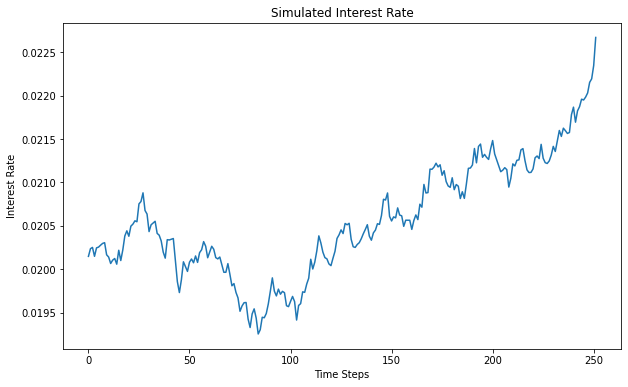

In [9]:
# Interest Rate simulation
interest_0 = 0.02  # Initial interest rate
mu_interest = 0.01  # Drift coefficient for interest rate
sigma_interest = 0.05  # Volatility coefficient for interest rate
days = 252
def simulate_gbm(S0, mu, sigma, T, days):
    """
    Simulate a GBM process

    :param S0: Initial value
    :param mu: Drift
    :param sigma: Volatility
    :param T: Time
    :param days: Number of trading days
    :return: GBM
    """
    dt = T / days
    t = np.linspace(0, T, days)
    W = np.random.standard_normal(size=days)
    W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(X)  # GBM
    return S

# Simulating the Interest Rate
interest_rate_simulation = simulate_gbm(interest_0, mu_interest, sigma_interest, T, days)

# Plotting the simulated Interest Rate
plt.figure(figsize=(10, 6))
plt.plot(interest_rate_simulation)
plt.title("Simulated Interest Rate")
plt.xlabel("Time Steps")
plt.ylabel("Interest Rate")
plt.show()

### Calculate $\frac{S(T)}{S(0)}$ use simulated data

In [10]:
dt = 1/N
S0 = 1.336

W_T = np.random.normal(0, np.sqrt(T))

num_points = days # Number of data points
r_d = interest_rate_simulation

# Time points for the data series
time_points = np.linspace(0, T, num_points)

# Numerical integration of r_d(s) over [0, T]
integral_r_d = np.trapz(r_d, time_points)

# Second term, which simplifies to sigma_s^2 * T / 2
integral_sigma_s_squared = 0.5 * sigma_s**2 * T

# Third term, which is sigma_s * W_T
integral_sigma_s_W_T = sigma_s * W_T

# Combine the terms and calculate the exponential
variable_value = np.exp(integral_r_d - integral_sigma_s_squared + integral_sigma_s_W_T)
variable_value


0.8592525831407841

## Step 3 Price Calculation with market data

In [11]:
### price calculation based on real date
def calculate_contract_price(N, start_date, end_date, T, Delta, k, Stock_Data, k_prime):
    """
    Calculate the price of the financial contract.

    Parameters:
    N (float): Notional in USD.
    L_0_T_Delta (float): 3-month USD forward rate between T and T + Delta observed at time 0.
    T (float): Maturity date in years.
    Delta (float): Settlement period in years (usually 0.25 years for 3 months).
    k (float): Relative strike price.

    Returns:
    float: Price of the contract.
    """
    S_0 = Stock_Data['Close'].loc[start_date]
    S_T = Stock_Data['Close'].loc[end_date]
    ''' 
    Forward rate calculationo and expectation
    L_T = 1
    L_0 = 1
    '''
    # Calculate the payoff at maturity
    payoff_at_maturity = max(0, ((k - S_T / S_0) * L_T/ L_0) - k_prime)

    # Calculate the contract price
    contract_price = N * payoff_at_maturity

    return contract_price

# By LRY

### calib.py

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm
from tabulate import tabulate
import requests
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

def read_sofr(ma_w = 90,ma=False):
    sofr_data = pd.read_excel('SOFR.xlsx')
    sofr_rates = sofr_data[['Rate (%)']]/100
    sofr_rates.loc[:,"dr"] = sofr_rates.loc[:,'Rate (%)'].diff()
    sofr_rates.rename(columns={'Rate (%)':"r"}, inplace=True)
    if ma:
        sofr_rates = sofr_rates.rolling(ma_w).mean().dropna()
        sofr_rates.loc[:,"dr"] = sofr_rates.loc[:,"r"].diff()
    return sofr_rates.dropna()

def read_stock():
    stock_data = yf.download('^STOXX50E','2018-11-01','2023-11-01')
    exchange_rate = yf.download('EURUSD=X','2018-11-01','2023-11-01')
    return stock_data, exchange_rate

def calibrate_quanto():
    stock_data, exchange_rate = read_stock()
    delta_f = stock_data["Close"].apply(np.log).diff().std() * np.sqrt(252)
    delta_x = exchange_rate["Close"].apply(np.log).diff().std() * np.sqrt(252)
    aligned_data = pd.merge(
        stock_data['Close'], exchange_rate['Close'], 
        how="inner", left_index=True, right_index=True)
    logret = aligned_data.apply(np.log).diff()

    rho_fx = logret.corr().values[0,1]
    sigma_s = (delta_f**2 + delta_x**2 + 2 * delta_f * delta_x * rho_fx)**0.5
    return sigma_s

def vasicek_regression_rol(df, dt=1/252, W=100):
    rate_colname = 'r'
    change_colname = "dr"
    X = df.loc[:, [rate_colname]]
    y = df.loc[:, change_colname]
    X = sm.add_constant(X)
    rols = RollingOLS(y, X, window=W)
    rres = rols.fit()
    params = rres.params.copy()
    params.loc[:,"b"] = params["const"] / dt
    params.loc[:,"a"] = -params[rate_colname] / dt
    params.loc[:,"sigma"] = np.sqrt(rres.mse_resid / dt)
    return params.loc[:,["a","b","sigma"]].dropna()

def cir_regression_rol(df, dt=1/252, W=100):
    rate_colname = 'r'
    change_colname = "dr"
    b1 = "sqrt(r)"
    b2 = "1/sqrt(r)"
    X = df.copy()
    X.loc[:,b1] = df.loc[:,rate_colname]**(1/2)
    X.loc[:,b2] = 1 / X.loc[:,b1]
    y = X.loc[:, change_colname] / X.loc[:,b2]
    X = X.loc[:,[b1, b2]]
    rols = RollingOLS(y, X, window=W)
    rres = rols.fit()
    params = rres.params.copy()
    params.loc[:,"a"] = -params[b1] / dt
    params.loc[:,"b"] = params[b2] /params.loc[:,"a"]/ dt
    params.loc[:,"sigma"] = np.sqrt(rres.mse_resid / dt)
    return params.loc[:,["a","b","sigma"]].dropna()

def calibrate(df, dt=1/252, W=200, model="vasicek"):
    if model == "vasicek":
        return vasicek_regression_rol(df, dt, W)
    elif model == "cir":
        return cir_regression_rol(df, dt, W)
    else:
        raise NotImplementedError


sigma_s = calibrate_quanto()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### sim.py

In [13]:
def bond_price_vasicek(
    a:float,
    b:float,
    sigma:float,
    T:int=1,
    r0:float=0.02,
    **kwargs
):  
    """Computes Vasicek bond price using Ricatti ODE"""
    # use A() and B() in Ricatti ODEs
    B = (1 - np.exp(-a*T)) / a
    A = (b/a - (sigma*sigma)/(2*a*a)) * (B - T) - (sigma * sigma * B * B) / (4 * a)
    return np.exp(A - B * r0)

def bond_price(
    r:np.ndarray,
    t:float=0.,
    maturity:float=1.,
    dt:float=1e-2,
    **kwargs
):
    """computes bond price vector using short rate samples"""
    debug = False
    if r.shape[1] < int(maturity // dt)+1:
        raise RuntimeError(
            ("Incorrect input shape. Number of time points "
             "must be sufficient for passsed time increment size."
             f"Minimum: {int(maturity//dt)+1}. Passed: {r.shape[1]}.")
        )
    r_horizon = r[:, round(t / dt):round(maturity/dt)+1]
    if debug:
        print("Orignal r shape:", r.shape)
        print("Passed time period:", f"t={t}, maturity={maturity}")
        print("Result time horizon shape:", r_horizon.shape)
    return np.exp(-(r_horizon * dt).sum(axis = 1))

def forward_term_rate(
    r:np.ndarray,
    t:float=0,
    accr_start:float=3.,
    accr_length:float=0.25,
    dt:float=1e-4,
    **kwargs
):
    """computes forward term rate vector using short rate samples"""
    b1 = bond_price(r, t, accr_start, dt=dt, **kwargs) 
    b2 = bond_price(r, t, accr_start+accr_length, dt=dt, **kwargs)
    return (b1 - b2) / (accr_length * b2)

def forward_term_rate_ratio(
    r:np.ndarray,
    t:float=0.,
    accr_start:float=3.,
    accr_length:float=0.25,
    dt:float=1e-4,
    **kwargs
):
    """This is the L(T,T,T+D) / L(0,T,T+D) ratio in the T-claim.
    The expression is simplified for optimized computation.
    """
    b1 = bond_price(r, accr_start, accr_start+accr_length, dt=dt, **kwargs) 
    b2 = bond_price(r, t, accr_start, dt=dt, **kwargs)
    b3 = bond_price(r, t, accr_start+accr_length, dt=dt, **kwargs)
    return (1 - b1) / (b2 - b3) * b3 / b1

def sim_vasicek(
    a:float,
    b:float,
    sigma:float,
    n:int=1000,
    T:int=1,
    dt:float=1e-2,
    r0:float=0.02,
    **kwargs
):
    """Simulate Vasicek short rate using Gaussian.
    
    Model: dr = (b-ar)dt + sigma*dW
    """
    m = int(T / dt)
    sqrt_dt = np.sqrt(dt)
    dr = np.zeros((n, m))
    r = np.zeros((n, m+1))
    r[:,0] = r0
    Z = np.random.randn(n, m)
    for t in range(m):
        inc = b - a * r[:,t]
        np.copyto(dr[:,t], dt * inc + sigma * Z[:,t] * sqrt_dt)
        np.copyto(r[:,t+1], r[:,t] + dr[:,t])
    return r

def sim_cir(
    a:float,
    b:float,
    sigma:float,
    n:int=1000,
    T:int=1,
    dt:float=1e-2,
    r0:float=0.02,
    **kwargs
):
    """Simulate CIR short rate using Gaussian.

    Model: dr = a(b-r)dt + sigma*\sqrt{r}dW
    """ 
    m = int(T / dt)
    sqrt_dt = np.sqrt(dt)
    dr = np.zeros((n, m))
    r = np.zeros((n, m+1))
    r[:,0] = r0
    Z = np.random.randn(n, m)
    for t in range(m):
        inc = a * (b - r[:,t])
        np.copyto(dr[:,t], dt * inc + sigma * Z[:,t] * sqrt_dt * np.sqrt(r[:,t]))
        np.copyto(r[:,t+1], r[:,t] + dr[:,t])
    return r

def sim_dothan(
    a: float,
    sigma:float,
    n:int=1000,
    T:int=1,
    dt:float=1e-2,
    r0:float=0.02,
    **kwargs
):
    """Simulate Dothan short rate using Gaussian.

    Model: dr/r = a*dt + sigma*dW
    """
    m = int(T / dt)
    sqrt_dt = np.sqrt(dt)
    dr = np.zeros((n, m))
    r = np.zeros((n, m+1))
    r[:,0] = r0
    Z = np.random.randn(n, m)
    dr = a * dt + sigma * sqrt_dt * Z
    r[:, 1:] = dr.cumsum(axis = 1) + r0
    return r


def sim_short_rate(
    kind = "vasicek",
    **kwargs
):
    if kind == "vasicek":
        return sim_vasicek(**kwargs)
    elif kind == "cir":
        return sim_cir(**kwargs)
    elif kind == "dothan":
        return sim_dothan(**kwargs)
    else:
        return NotImplementedError
    
def eval_quanto(r_d, sigma_s, dt=1/252):
    # Extract short rate sample shape
    num_samples, num_points = r_d.shape
    T = (num_points-1) * dt

    # Time points for the data series
    time_points = np.linspace(0, T, num_points)

    # Numerical integration of r_d(s) over [0, T]
    integral_r_d = np.trapz(r_d, time_points)

    # Second term, which simplifies to sigma_s^2 * T / 2
    integral_sigma_s_squared = 0.5 * sigma_s**2 * T

    # Third term, which is sigma_s * W_T
    integral_sigma_s_W_T = sigma_s * np.random.randn(num_samples)

    # Evaluate final value
    quanto_ratio_sample = np.exp(
        integral_r_d - integral_sigma_s_squared + integral_sigma_s_W_T
    )
    return quanto_ratio_sample

if __name__ == "__main__":
    import time
    params = {
        "a": 0.5,
        "b": 0.04,
        "sigma": 0.2,
        "n":100,
        "t":1.5,
        "T":5.,
        "maturity": 2.25,
        "dt":1e-4,
        "r0":0.02
    }
    start = time.time()
    r = sim_short_rate(kind="vasicek", **params)
    L1 = forward_term_rate(
        r=r, t=3., accr_start=3., accr_length=0.25, dt = 1e-4
    )
    L2 = forward_term_rate(
        r=r, t=0., accr_start=3., accr_length=0.25, dt = 1e-4
    )
    print("L1:", L1)
    print("L2:", L2)
    Ratio = forward_term_rate_ratio(
        r=r, accr_start=3., accr_length=0.25, dt = 1e-4
    )
    print("Method 1 result:", (L1/L2).mean())
    print("Method 2 result:", Ratio.mean())
    print("Total runtime:", time.time() - start)

L1: [-0.38570984 -0.14295279  0.22003398  0.10611002  0.21331302  0.10768488
  0.21856938  0.3257168  -0.11073715  0.40582255  0.28156169  0.58647597
  0.45083026  0.38506965  0.27280834  0.29263505 -0.11292332  0.10427678
  0.03272406 -0.01390979  0.21555805 -0.27249561 -0.22399786  0.09451925
 -0.05801996  0.08173346 -0.08298651 -0.14403574 -0.11112058  0.2075646
  0.09479729 -0.12199337  0.11702983  0.24915439 -0.27832769 -0.14545989
 -0.28814982  0.12430579  0.25093108 -0.22432485  0.10475258 -0.00793357
  0.22025713  0.07711086  0.17256062  0.03750394 -0.03048359  0.27008802
 -0.0947541  -0.24383084 -0.17570901  0.22516426  0.29283816 -0.02810651
  0.08821514 -0.11731053  0.22252733 -0.1306023  -0.00407554 -0.05127572
 -0.05743865  0.00710768  0.3031899   0.0077895  -0.09536444 -0.35682309
  0.0781201  -0.21401959 -0.0239593   0.21163618  0.25831364  0.09819558
  0.4918512  -0.18900033  0.05196136  0.12466738  0.40806348 -0.17763321
  0.11559194  0.2938477   0.16864556  0.28599197

### from Main.py

In [35]:
 def main(
    model="vasicek", 
    N=1, k=1, kprime=1,n=100000, dt=1/252, 
    T=3, Delta=0.25,
    loud=True, ma_w = 90
):
    # read daily sofr rates data
    sofr = read_sofr(ma_w = 90, ma=True)
    
    # calibrate model for both t=0, t=T
    # parameter at t=0, using one year to calibrate
    a0, b0, sigma0 = calibrate(df=sofr, model=model, W=252).iloc[-1].values
    # expected parameter at t=T, using five years to calibrate
    # assume parameters' long term behavior converges to historical trend
    aT, bT, sigmaT = calibrate(df=sofr, model=model, W=len(sofr)).iloc[-1].values
    # extract last sofr observation as r0
    r0 = sofr.loc[len(sofr), "r"]

    # simulate [0,T] using params at t=0
    sample_0 = sim_short_rate(kind=model, a=a0, b=b0, sigma=sigma0, n=n,T=T+Delta, dt=dt, r0=r0)
    # extract simulated r(T) average as r(T) for simulating [T,T+Delta]
    ErT = sample_0.mean(axis=0)[int(T/dt)-1]
    # simulate [T,T+Delta] using params at t=T
    sample_T = sim_short_rate(kind=model, a=aT, b=bT, sigma=sigmaT, n=n,T=Delta, dt=dt, r0=ErT)

    # using simulate short rate sample paths, transform to term rates
    L0 = forward_term_rate(
        r=sample_0, t=0., accr_start=T, accr_length=Delta, dt=dt
    )
    LT = forward_term_rate(
        r=sample_T, t=(T-T), accr_start=(T-T), accr_length=Delta, dt=dt
    )
    # obtain term rate ratio
    L_ratio = (LT/L0)

    # calibrate quanto using data from yfinance
    sigma_s = calibrate_quanto()

    # using calibrate quanto volatility, simulate quanto value
    # use only short rate in [0,T]
    r_d = sample_0[:,:int(T/dt+1)]
    quanto_ratio = eval_quanto(r_d=r_d, sigma_s=sigma_s,dt=dt)

    # finally, evaluate T-claim
    # T-claim: N*max[0, (k-quanto_ratio)*(L_ratio-kprime)]

    # stochastic discount factor
    discount = bond_price(r_d, t=0, maturity=T,dt=dt)

    claim = discount * N * np.maximum(
        (k - quanto_ratio) * (L_ratio - kprime), 0
    )
    info = a0, b0, sigma0, aT, bT,sigmaT,r0,ErT, L_ratio.mean(), quanto_ratio.mean(),discount.mean()
    return claim, sample_T, sample_0, info


claim_cir, sample_T_cir, sample_0_cir,info_cir = main(
    model="cir", N=1,k=1,kprime=1,n=100000,dt=1/252,
    T=3, Delta=0.25, loud =True
)
a0, b0, sigma0, aT, bT,sigmaT,r0,ErT, L_ratio_mean, quanto_ratio_mean,discount_mean = info_cir
print("Model:", "cir")
print(f"Parameters at t=0:")
print(f"\ta = {a0}")
print(f"\tb = {b0}")
print(f"\tsigma = {sigma0}")
print(f"Parameters at t=T:")
print(f"\ta = {aT}")
print(f"\tb = {bT}")
print(f"\tsigma = {sigmaT}")
print("R0:", r0)
print("E[RT]:", ErT)
print("L_ratio mean:", L_ratio_mean)
print("quanto_ratio mean:", quanto_ratio_mean)
print("Average bond price p(0,T):", discount_mean)

print("Claim price (std):", f"{claim_cir.mean()} ({claim_cir.std()})")
        

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Model: cir
Parameters at t=0:
	a = 0.03480908015857514
	b = 0.026642822968540838
	sigma = 0.00010430098309434862
Parameters at t=T:
	a = 0.01518078156100891
	b = 0.0006604047861360866
	sigma = 0.0002065558596481927
R0: 0.024361111111111115
E[RT]: 0.02458696728780192
L_ratio mean: 0.9977419042131941
quanto_ratio mean: 1.0248004066433152
Average bond price p(0,T): 0.9291124529892333
Claim price (std): 0.0002172350389751047 (0.000394680499419636)


# compare cir and vasecik

In [36]:
claim_vas, sample_T_vas, sample_0_vas, info_vas = main(
    model="vasicek", N=1,k=1,kprime=1,n=100000,dt=1/252,
    T=3, Delta=0.25, loud =True
)
a0, b0, sigma0, aT, bT,sigmaT,r0,ErT, L_ratio_mean, quanto_ratio_mean,discount_mean = info_vas
print("Model:", "vasicek")
print(f"Parameters at t=0:")
print(f"\ta = {a0}")
print(f"\tb = {b0}")
print(f"\tsigma = {sigma0}")
print(f"Parameters at t=T:")
print(f"\ta = {aT}")
print(f"\tb = {bT}")
print(f"\tsigma = {sigmaT}")
print("R0:", r0)
print("E[RT]:", ErT)
print("L_ratio mean:", L_ratio_mean)
print("quanto_ratio mean:", quanto_ratio_mean)
print("Average bond price p(0,T):", discount_mean)

print("Claim price (std):", f"{claim_vas.mean()} ({claim_vas.std()})")

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Model: vasicek
Parameters at t=0:
	a = 2.3103984692044075
	b = 0.059068711012689644
	sigma = 0.0007068570821635202
Parameters at t=T:
	a = 0.44995852794684377
	b = 0.0011103864184346228
	sigma = 0.001516950276625044
R0: 0.024361111111111115
E[RT]: 0.02556511576451714
L_ratio mean: 0.9501669938802697
quanto_ratio mean: 1.0273463104639542
Average bond price p(0,T): 0.9265558356111335
Claim price (std): 0.004797086969106745 (0.008198605095933936)


In [37]:
## create a table for result display 
model_comp = pd.DataFrame(columns=["cir", "vasicek"],
                          index=["Claim price", "Claim std"])
model_comp["cir"]["Claim price"] = claim_cir.mean()
model_comp["cir"]["Claim std"] = claim_cir.std()
model_comp["vasicek"]["Claim price"] = claim_vas.mean()
model_comp["vasicek"]["Claim std"] = claim_vas.std()
model_comp

,cir,vasicek
Claim price,0.000217,0.004797
Claim std,0.000395,0.008199


# Compare resuls with different k and k'

In [38]:
kkps =[[1,1],[1,0],[0,1],[1,2],[2,1],[0,0],[2,2],[0,2],[2,0]]
price_wrt_ks = pd.DataFrame(columns=["k , k' ", "claim price", "std" ],index=range(0,len(kkps)))
prices = pd.DataFrame(columns = range(0,3), index = range(0,3))
for i in range(len(kkps)):
    kkp = kkps[i]
    claim_vas, sample_T_vas, sample_0_vas, info_vas = main(
    model="cir", N=1,k=kkp[0],kprime=kkp[1],n=100000,dt=1/252,
    T=3, Delta=0.25, loud =True)
    a0, b0, sigma0, aT, bT,sigmaT,r0,ErT, L_ratio_mean, quanto_ratio_mean,discount_mean = info_vas
    price_wrt_ks["k , k' "][i] = "k = " + str(kkp[0]) + ", k' = " + str(str(kkp[1]))
    price_wrt_ks["claim price"][i] = claim_vas.mean()
    price_wrt_ks["std"][i] = claim_vas.std()
    prices[kkp[1]][kkp[0]] = claim_vas.mean()
price_wrt_ks

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,"k , k'",claim price,std
0,"k = 1, k' = 1",0.000217,0.000393
1,"k = 1, k' = 0",0.072512,0.100562
2,"k = 0, k' = 1",0.00216,0.001214
3,"k = 1, k' = 2",0.095349,0.148513
4,"k = 2, k' = 1",0.000011,0.000092
5,"k = 0, k' = 0",0.0,0.0
6,"k = 2, k' = 2",0.000116,0.005655
7,"k = 0, k' = 2",0.953713,0.214585
8,"k = 2, k' = 0",0.904119,0.214728


In [39]:
price_wrt_ks.sort_values(by=['claim price']).set_index("k , k' ")

,claim price,std
"k , k'",,
"k = 0, k' = 0",0.0,0.0
"k = 2, k' = 1",0.000011,0.000092
"k = 2, k' = 2",0.000116,0.005655
"k = 1, k' = 1",0.000217,0.000393
"k = 0, k' = 1",0.00216,0.001214
"k = 1, k' = 0",0.072512,0.100562
"k = 1, k' = 2",0.095349,0.148513
"k = 2, k' = 0",0.904119,0.214728
"k = 0, k' = 2",0.953713,0.214585


# TODO: compare different rolling window length

In [40]:
ma_ws = [30, 90, 180, 360]
prices_ma = pd.DataFrame(columns=["moving average window", "claim price", "std" ], index = range(len(ma_ws)))
for i in range(len(ma_ws)):
    ma_w = ma_ws[i]
    claim_vas, sample_T_vas, sample_0_vas, info_vas = main(
    model="cir", N=1,k=kkp[0],kprime=kkp[1],n=100000,dt=1/252,
    T=3, Delta=0.25, loud =True, ma_w = ma_w)
    a0, b0, sigma0, aT, bT,sigmaT,r0,ErT, L_ratio_mean, quanto_ratio_mean,discount_mean = info_vas
    prices_ma["moving average window"][i] = ma_w
    prices_ma["claim price"][i] = claim_vas.mean()
    prices_ma["std"][i] = claim_vas.std()
prices_ma

/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/zoeyzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,moving average window,claim price,std
0,30,0.904178,0.213444
1,90,0.904504,0.21373
2,180,0.905695,0.212996
3,360,0.903351,0.213763
